# 🗣️ Voice Classifier 101

**Goal:** Given a short `.wav` recording, predict **who** is talking (e.g. Alice vs. Bob).

**How it works (high level):**  
1. **Listen:** We turn each audio clip into a list of numbers (features).  
2. **Learn:** We show these features and labels (who’s speaking) to a simple machine learner (`scikit-learn`’s SVM).  
3. **Guess:** The learner makes predictions on new clips!

## 📦 0. Setup: Install what we need

In [3]:
!pip install librosa scikit-learn matplotlib soundfile

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp312-abi3-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl (1.1 MB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soxr-0.5.0.post1-cp312-abi3-macosx_11_0_arm64.whl (156 kB)


## 🗂️ 1. Prepare a tiny dataset

1. Create a folder structure in your project:
    ```
    data/
    ├─ Alice/
    │    ├─ alice1.wav
    │    ├─ alice2.wav
    │    └─ alice3.wav
    └─ Bob/
        ├─ bob1.wav
        ├─ bob2.wav
        └─ bob3.wav
    ```
2. Record 3 short clips (5–10 s) of **Alice** and 3 of **Bob** on your phone or computer.
3. Save them as `.wav` files in the folders above.

## 🔧 2. Import libraries

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## 🎶 3. How does the computer “hear” sound?

A `.wav` file is just a sequence of numbers (amplitudes over time). We can **plot** the waveform to see the squiggles!

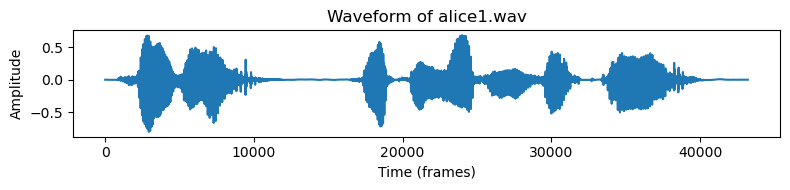

In [5]:
# Load and plot one example
path = "data/Alice/alice1.wav"
y, sr = librosa.load(path, duration=5)

plt.figure(figsize=(8, 2))
plt.plot(y)
plt.title("Waveform of alice1.wav")
plt.ylabel("Amplitude")
plt.xlabel("Time (frames)")
plt.tight_layout()
plt.show()

## 🧩 4. Extract “features” (MFCCs)

- Raw waveforms are long; we summarize them with **MFCCs** (13 numbers that capture the “shape” of the sound).
- The computer learns from these fixed-size feature vectors.

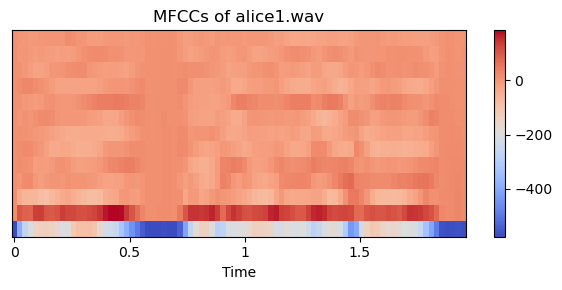

In [6]:
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, duration=5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1)

# Visualize MFCC heatmap for alice1
mf = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(6, 3))
librosa.display.specshow(mf, x_axis='time')
plt.colorbar()
plt.title("MFCCs of alice1.wav")
plt.tight_layout()
plt.show()

## 🏗️ 5. Build our dataset arrays

In [7]:
X, y_labels = [], []

for speaker in ["Alice", "Bob"]:
    folder = f"data/{speaker}"
    for fname in os.listdir(folder):
        if fname.endswith(".wav"):
            feats = extract_mfcc(os.path.join(folder, fname))
            X.append(feats)
            y_labels.append(speaker)

X = np.array(X)
y_labels = np.array(y_labels)
print("Feature matrix shape:", X.shape)  # e.g. (6, 13)

Feature matrix shape: (6, 13)


## 🔀 6. Split into train/test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.33, random_state=42
)
print(f"Training on {len(X_train)} clips; testing on {len(X_test)} clips")

Training on 4 clips; testing on 2 clips


## 🤖 7. Train a simple SVM classifier

- We represent each voice clip with 13 numbers.

    | MFCC Features (13 numbers) | Speaker |
    | -------------------------- | ------- |
    | `[12.3, -4.5, 0.9, ...]`   | Alice   |
    | `[8.1, -2.0, 3.5, ...]`    | Bob     |
    | ...                        | ...     |

<br>

- The computer looks at all the dots and tries to separate them: one side for Alice, one side for Bob.

    ![illustration](./illustration.png)

    <br>
    
    > Open [learning_demo.html](./learning_demo.html) with your browser for the example.

In [9]:
model = SVC(kernel="linear")
model.fit(X_train, y_train)
print("Model trained successfully!")

Model trained successfully!


## 📊 8. See how well we did

              precision    recall  f1-score   support

       Alice       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


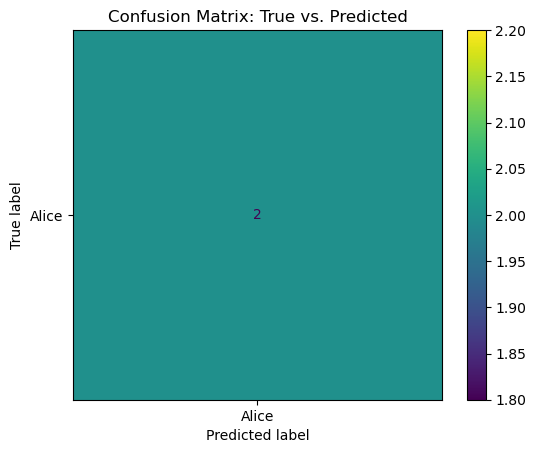

In [10]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix: True vs. Predicted")
plt.show()

## 🎤 9. Try a brand-new recording

In [11]:
# Record and save a fresh clip as "bob_new.wav" in data/Bob/, then:
new_path = "data/Bob/bob3.wav"
new_feats = extract_mfcc(new_path).reshape(1, -1)
guess = model.predict(new_feats)[0]
print("I think this is:", guess)

I think this is: Bob


## 🏁 10. What did we learn?

1. **Sound → numbers** via MFCCs.  
2. **Numbers + labels** teach the computer.  
3. A **simple SVM** can separate speakers.  
4. **Visuals** (waveform, MFCC heatmap, confusion matrix) help us understand.

🎉 **Congrats!** You’ve built a mini voice-recognition AI. Try adding more friends, clips, or classifiers to extend it!